**Upload File**

In [1]:
from google.colab import files

uploaded = files.upload()

Saving jabodetabek_house_price.csv to jabodetabek_house_price.csv


## **1. Library**

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

## **2. Load Data**

In [3]:
data = pd.read_csv('jabodetabek_house_price.csv')

## **3. Eksplorasi Data**

In [4]:
# 2. Data Exploration
print("Data Shape:", data.shape)
print("\nMissing Values:\n", data.isnull().sum())
print("\nData Types:\n", data.dtypes)

Data Shape: (3553, 27)

Missing Values:
 url                        0
price_in_rp                0
title                      0
address                    0
district                   0
city                       0
lat                        0
long                       0
facilities                 0
property_type              1
ads_id                     4
bedrooms                  34
bathrooms                 29
land_size_m2               2
building_size_m2           2
carports                   0
certificate              141
electricity                0
maid_bedrooms              0
maid_bathrooms             0
floors                     6
building_age            1445
year_built              1445
property_condition       246
building_orientation    1647
garages                    0
furnishing               387
dtype: int64

Data Types:
 url                      object
price_in_rp             float64
title                    object
address                  object
district             

## **4. Preprocessing Data**

In [5]:
# Drop unnecessary columns
data = data.drop(['url', 'title', 'address', 'ads_id'], axis=1)

In [6]:
# Handle missing values for numerical columns
num_cols = data.select_dtypes(include=['int64', 'float64']).columns
for col in num_cols:
    if data[col].isnull().sum() > 0:
        data[col] = data[col].fillna(data[col].median())

In [7]:
# Handle missing values for categorical columns
cat_cols = data.select_dtypes(include=['object']).columns
for col in cat_cols:
    if data[col].isnull().sum() > 0:
        data[col] = data[col].fillna('Unknown')

In [8]:
# Extract year from 'year_built' or use 'building_age' if missing
data['property_age'] = 2023 - data['year_built']
data.loc[data['property_age'].isnull(), 'property_age'] = data['building_age']

In [9]:
# Create binary features from facilities
data['has_pool'] = data['facilities'].str.contains('Kolam Renang', case=False).astype(int)
data['has_security'] = data['facilities'].str.contains('Keamanan', case=False).astype(int)
data['has_park'] = data['facilities'].str.contains('Taman', case=False).astype(int)

In [10]:
# Encode categorical variables
label_encoders = {}
for col in cat_cols:
    if col != 'facilities':  # Skip facilities as we've extracted features
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col].astype(str))
        label_encoders[col] = le

In [11]:
# Drop original facilities column
data = data.drop('facilities', axis=1)

## **5. Pemisahan Fitur dan Target**

In [12]:
X = data.drop('price_in_rp', axis=1)
y = np.log1p(data['price_in_rp'])

## **6. Split Data Training dan Testing**

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **7. Preprocessing Pipeline**

In [27]:
# Define numerical and categorical features
num_features = X.select_dtypes(include=['int64', 'float64']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [28]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features)
    ],
    remainder='passthrough'  # tetapkan fitur selain numerik
)

In [29]:
# Ganti pipeline model
pipeline_gb = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])


In [30]:
# Tuning hyperparameter
param_grid_gb = {
    'regressor__n_estimators': [100, 200],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__max_depth': [3, 5]
}

## **8. Model Gradient Boosting**

In [31]:
grid_search_gb = GridSearchCV(
    pipeline_gb,
    param_grid_gb,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)


In [32]:
grid_search_gb.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['district', 'city', 'lat', 'long', 'property_type', 'bedrooms',
       'bathrooms', 'land_size_m2', 'building_size_m2', 'carports',
       'certificate'...
       'floors', 'building_age', 'year_built', 'property_condition',
       'building_orientation', 'garages', 'furnishing', 'property_age',
       'has_pool', 'has_security', 'has_park'],
      dtype='object'))])),
                                       ('regressor',
                                        GradientBoostingRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__learning_rate': [0.05, 0.1],
                         'regressor__max_depth': [3, 5],
                         'regressor__n_estimators': [100, 200]},
             scoring='neg_mean_squared_error', verbose=1)

## **9. Evaluasi Model**

In [33]:
y_pred_gb = grid_search_gb.predict(X_test)
print("Eksperimen 3 - Gradient Boosting")
print("Best Params:", grid_search_gb.best_params_)
print("MAE:", mean_absolute_error(y_test, y_pred_gb))
print("MSE:", mean_squared_error(y_test, y_pred_gb))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_gb)))
print("R2 Score:", r2_score(y_test, y_pred_gb))

Eksperimen 3 - Gradient Boosting
Best Params: {'regressor__learning_rate': 0.05, 'regressor__max_depth': 5, 'regressor__n_estimators': 200}
MAE: 0.20043207113591138
MSE: 0.09782547563068868
RMSE: 0.31277064381218495
R2 Score: 0.9214308461083428


## **10. Feature Importance**

In [34]:
# Visualisasi Feature Importance
best_model_gb = grid_search_gb.best_estimator_
importances = best_model_gb.named_steps['regressor'].feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

## **11. Visualisasi**

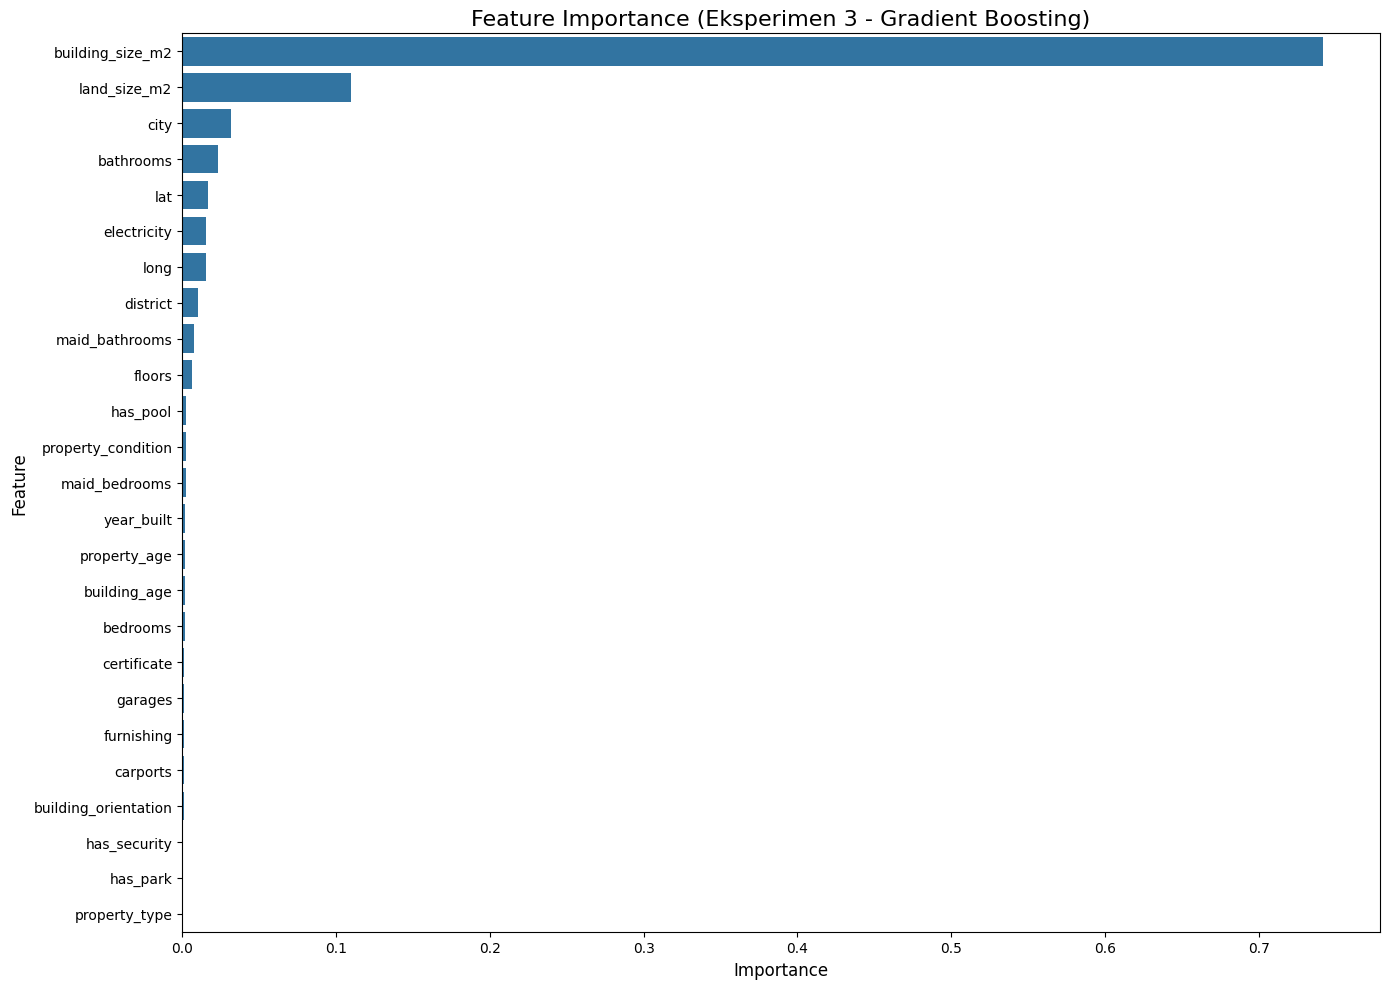

In [35]:
plt.figure(figsize=(14, 10))
sns.barplot(x=importances[indices], y=np.array(feature_names)[indices], orient='h')
plt.title('Feature Importance (Eksperimen 3 - Gradient Boosting)', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

**Kesimpulan 3**

Pada eksperimen ketiga, model Gradient Boosting Regressor menghasilkan performa yang sangat baik dengan R² Score sebesar 0.9214, artinya model mampu menjelaskan sekitar 92% variasi harga rumah. Nilai error juga rendah, dengan MAE hanya 0.20 dan RMSE sekitar 0.31, menandakan bahwa prediksi model cukup presisi dan stabil. Peningkatan akurasi ini dicapai berkat penggunaan model Gradient Boosting yang lebih kuat dalam menangani kompleksitas data, serta penerapan tuning hyperparameter (learning_rate, max_depth, n_estimators) yang optimal. Dibandingkan eksperimen sebelumnya, Gradient Boosting sedikit lebih akurat karena lebih baik dalam menangkap pola non-linear dan outlier, menjadikannya pilihan model yang sangat baik untuk prediksi harga rumah.